In [ ]:
!pip install pyLDAvis

In [ ]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az

from gensim import corpora
from gensim.models import LdaModel

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Q1

In [ ]:
# DO NOT MODIFY THIS CODE
website_visits_data = np.loadtxt('https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/website_visits.csv', delimiter=',')

## (a)

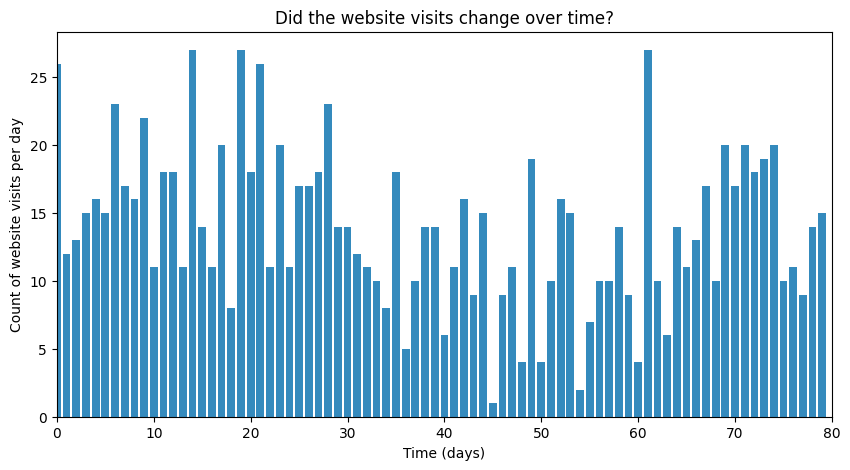

In [ ]:
n_website_visits_data = len(website_visits_data)
plt.figure(figsize=(10,5))
plt.bar(np.arange(n_website_visits_data), website_visits_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("Count of website visits per day")
plt.title("Did the website visits change over time?")
plt.xlim(0, n_website_visits_data);


The trend in the data indicates switchpoints as the website visits seems to peak in two areas. The reason for this trend could be due to some incentive or real-life event which draws users to the website at certain times. One switchpoint is approximately day 30 where the visits start to decrease.

## (b)

In [ ]:
# DO NOT MODIFY THIS CODE

param_names = ['tau_1', 'tau_2', 'lambda_1', 'lambda_2', 'lambda_3']

double_switchpoint_model = pm.Model()

with double_switchpoint_model:

  # Define priors
  # YOUR CODE STARTS HERE (FILL IN THE BLANKS)
  alpha = 1/np.mean(website_visits_data)
  tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=79)
  tau_2 = pm.DiscreteUniform("tau_2", lower=0, upper=79)
  lambda_1 = pm.Exponential("lambda_1", 1/np.mean(website_visits_data))
  lambda_2 = pm.Exponential("lambda_2", 1/np.mean(website_visits_data))
  lambda_3 = pm.Exponential("lambda_3", 1/np.mean(website_visits_data))
  idx =  np.arange(n_website_visits_data)
  lambda_12 = pm.math.switch(idx < tau_1, lambda_1, lambda_2)
  lambda_ =pm.math.switch(idx < tau_2, lambda_12, lambda_3)
  # Define likelihood (conditioned on observed data)
  likelihood = pm.Poisson("visits", lambda_, observed=website_visits_data)
  # Sample from posterior
  trace = pm.sample(1000, random_seed=45)


## (c)

In [ ]:
# Function to: (a) plot histogram of posterior samples (b) display mean and 94% HDI of posterior samples

def plot_posterior(param_name, trace):

    # (a) Plot histogram of posterior samples of passed parameter
    ax = sns.histplot(trace.posterior[param_name].values.flatten(),kde=True)
    ax.set_xlim(0, np.max(trace.posterior[param_name].values.flatten()))
    plt.xlabel(param_name)
    plt.ylabel('Number of Samples')
    plt.title(f'Histogram of Posterior Samples of {param_name}')


    # (b) Display mean and 94% HDI of posterior samples of passed parameter (round to 2 decimal places)
    print(f"\nMean of {param_name}: {np.mean(trace.posterior[param_name].values.flatten()):.2f}")
    hdi = az.hdi(trace.posterior[param_name].values.flatten())
    print(f"94% HDI of {param_name}: {hdi}")

    plt.show()
    return None


Mean of tau_1: 50.74
94% HDI of tau_1: [22 76]


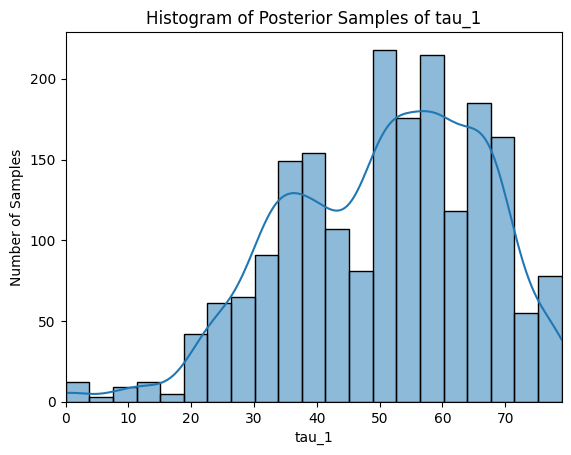


Mean of tau_2: 29.76
94% HDI of tau_2: [27 33]


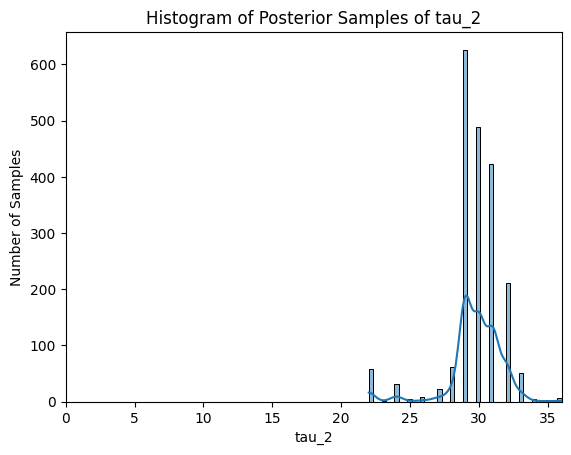


Mean of lambda_1: 17.10
94% HDI of lambda_1: [15.62738205 18.42165738]


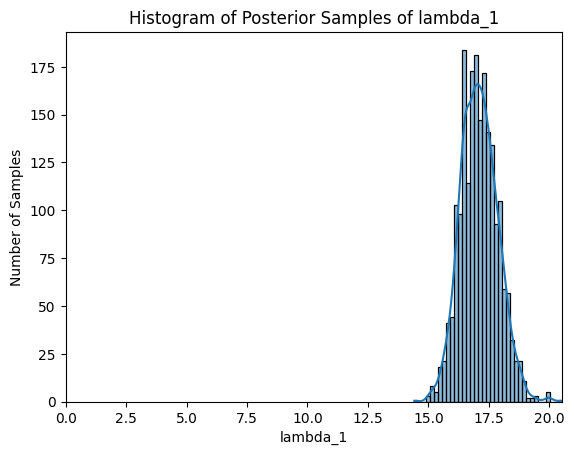


Mean of lambda_2: 13.70
94% HDI of lambda_2: [1.67208128e-03 3.70375633e+01]


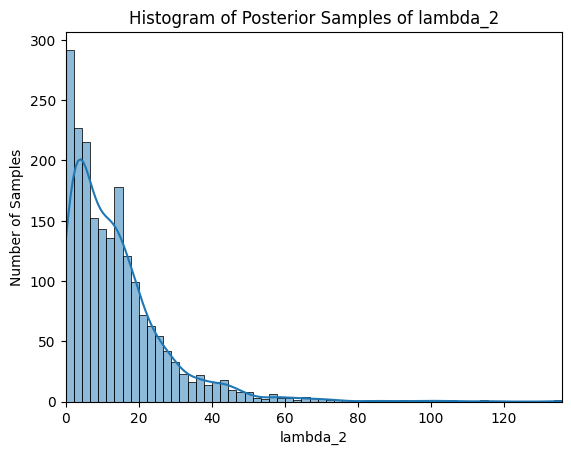


Mean of lambda_3: 12.05
94% HDI of lambda_3: [11.08642295 12.9141061 ]


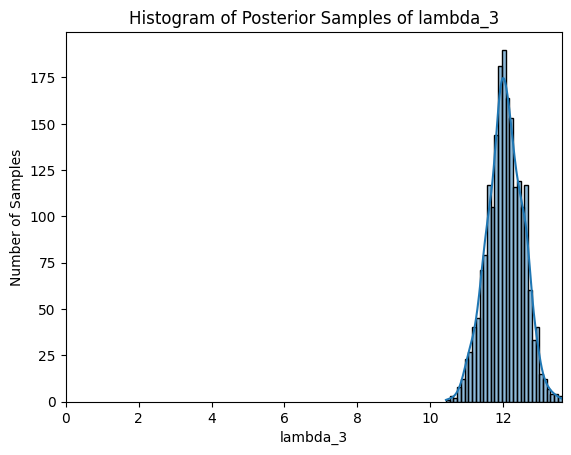

In [ ]:
# DO NOT MODIFY THIS CODE
for param_name in param_names:
    plot_posterior(param_name, trace)
    plt.show()

(i) The current model is not a good fit for all parameters. For example, for tau_1 and lambda_2 the 94% HDI shows a very wide range ([22 76] and [1.67208128e-03 3.70375633e+01] respectively)  which indicates uncertainty. A better model would have narrower ranges for these parameters.

(ii) The histograms do not align with what is expected from the observed trends. The switch points do not align with the trend as tau_1 should be less than tau_2 and the mean does not show that in this case.

## (d)

In [ ]:
# DO NOT MODIFY THIS CODE

double_switchpoint_model_adjusted = pm.Model()

with double_switchpoint_model_adjusted:

  # Define priors
 # YOUR CODE STARTS HERE (FILL IN THE BLANKS)
  alpha = 1/np.mean(website_visits_data)
  tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=79)
  tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=79)
  lambda_1 = pm.Exponential("lambda_1", 1/np.mean(website_visits_data))
  lambda_2 = pm.Exponential("lambda_2", 1/np.mean(website_visits_data))
  lambda_3 = pm.Exponential("lambda_3", 1/np.mean(website_visits_data))
  idx =  np.arange(n_website_visits_data)
  lambda_12 = pm.math.switch(idx < tau_1, lambda_1, lambda_2)
  lambda_ =pm.math.switch(idx < tau_2, lambda_12, lambda_3)
  # Define likelihood (conditioned on observed data)
  likelihood = pm.Poisson("count", lambda_, observed=website_visits_data)
  # Sample from posterior
  trace_adjusted =pm.sample(1000, random_seed=45)

The deficiency in this model is the lower bound for tau_2. The lower bound for tau_2 cannot be the same as tau_1 as indicated in the model because the switchpoint tau_2 occurs after tau_1 and should have a lower bound at least equal to tau_1. To fix this, the lower bound in the prior definition for tau_2 should be adjusted to tau_1.

## (e)


Mean of tau_1: 30.69
94% HDI of tau_1: [29 33]


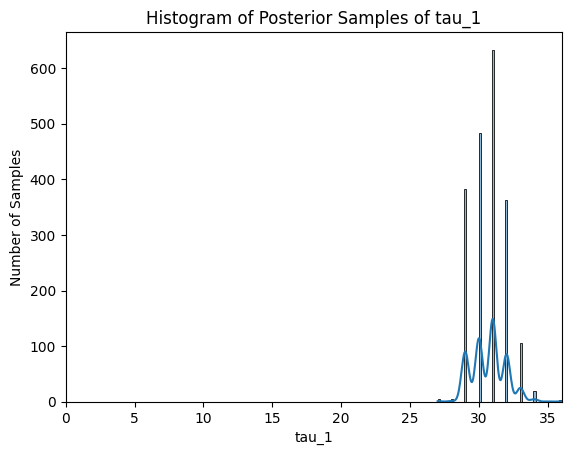


Mean of tau_2: 63.01
94% HDI of tau_2: [60 68]


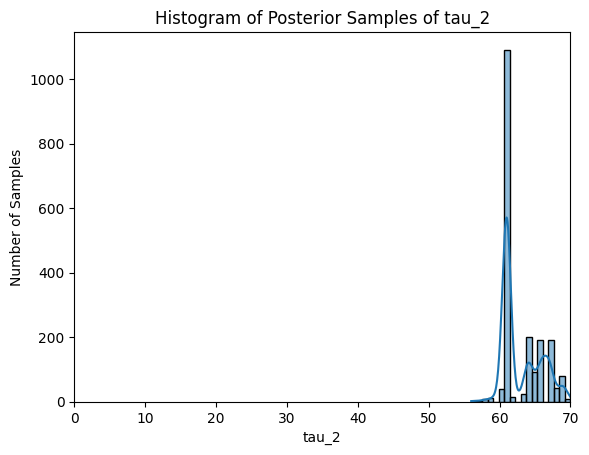


Mean of lambda_1: 17.06
94% HDI of lambda_1: [15.69482114 18.4503709 ]


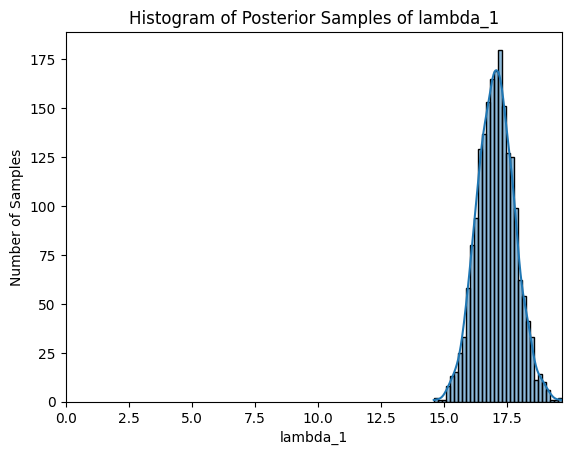


Mean of lambda_2: 10.43
94% HDI of lambda_2: [ 9.28130353 11.53949614]


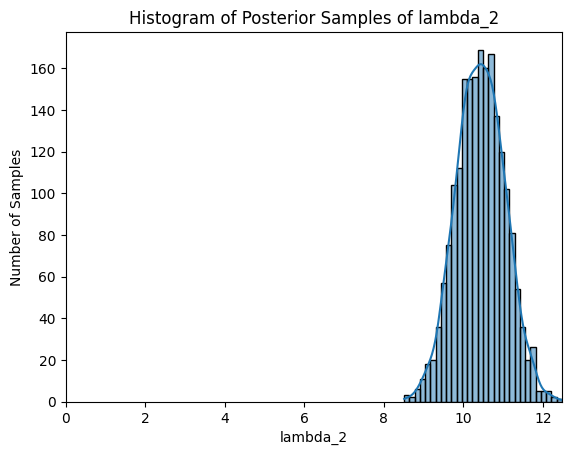


Mean of lambda_3: 14.92
94% HDI of lambda_3: [13.08796345 16.68685654]


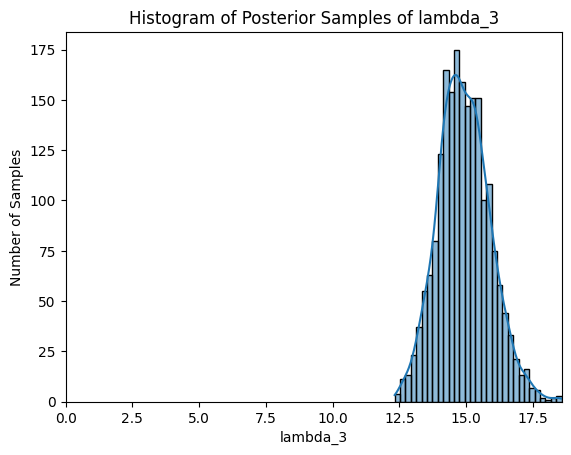

In [ ]:
# YOUR CODE GOES HERE
for param_name in param_names:
    plot_posterior(param_name, trace_adjusted)
    plt.show()


(i) This model is a better fit for the data. This is indicated by the improved HDI ranges for tau_1 and lambda_2 which are now narrower than they were in the original model.

(ii) The histograms now align with my expectations for the data. tau_1 is in the HDI range [29 33] and tau_2 is in the range [60 68]. When looking at the first histogram it is clear that this is a good estimate for the switchpoints.

# Q2

In [ ]:
topic_df = pd.read_csv('https://raw.githubusercontent.com/MIE223-2024/course-datasets/main/topic_dataset.csv')
topic_df["preprocessed"] = topic_df["preprocessed"].apply(lambda x: ast.literal_eval(x))
topic_df.head()

,document,preprocessed
0,Hi Xperts!\n\nHow can I move the cursor with t...,"[xperts, cursor, keyboard, cursor, key, mouse,..."
1,Where can I obtain a copy of the Open Look wid...,"[obtain, copy, open, look, widget, obtainable,..."
2,\nYou're right about the signal being strong. ...,"[right, signal, strong, live, west, philadelph..."
3,"\nHe's a Canadian ""thing"". Former coach of the...","[canadian, thing, coach, boston, bruin, colora..."
4,"\n\n Heck, I seem to feel like that *ev...","[heck, feel, like, time, including, cafeteria,..."


## (a)

In [ ]:
# Build the id2word dictionary and the corpus (map the word to id)
texts = topic_df['preprocessed'].tolist()
dictionary = corpora.Dictionary(texts)
print('Number of unique tokens before pre-processing: ', len(dictionary))

# Remove stop words from a stop words set; merged from nltk and scikit-learn's built-in list and words
stoplist = set(stopwords.words('english')).union(set(ENGLISH_STOP_WORDS))
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist
            if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

# Filter out words that appear in less than 2 documents (appear only once)
# no_above argument specify, e.g. no_above = 0.5 would remove words that appear in more than 50% of the documents
dictionary.filter_extremes(no_below = 2)
dictionary.filter_extremes(no_above = 0.5)

# Remove gaps in id sequence after words that were removed
dictionary.compactify()
print('Number of unique tokens after pre-processing: ', len(dictionary))

# Convert words to the "learned" word id
corpus = [dictionary.doc2bow(text) for text in texts]


Number of unique tokens before pre-processing:  49388
Number of unique tokens after pre-processing:  12325


## (b)

In [ ]:
# Train LDA model

topic_model = LdaModel(corpus, id2word = dictionary, num_topics = 10, iterations = 100, eval_every = None, random_state = 100, minimum_probability = 0)


In [ ]:
# Display LDA visualization

lda_topic_diagram = pyLDAvis.gensim_models.prepare(topic_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_topic_diagram)
lda_topic_diagram


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.098355 -0.008029       1        1  17.307905
1     -0.183558 -0.107652       2        1  10.126147
2      0.012400  0.163457       3        1   5.405787
3     -0.050902  0.030655       4        1   7.410404
4      0.085787  0.043409       5        1   4.848732
5     -0.055921  0.036867       6        1   9.956483
6     -0.121706 -0.049556       7        1  13.659480
7      0.014280  0.035179       8        1  11.075134
8      0.005995 -0.002908       9        1  14.641401
9      0.195271 -0.141422      10        1   5.568527, topic_info=            Term         Freq        Total Category  logprob  loglift
126         game  2219.000000  2219.000000  Default  30.0000  30.0000
633     armenian  1763.000000  1763.000000  Default  29.0000  29.0000
3022        bike   755.000000   755.000000  Default  28.0000  28.0000
88          team  1462.000000  1462.000000  Default  27.0000  27.0000
1539         jew   616.000000   616.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1614  university   138.175798   712.182357  Topic10  -5.5859   1.2482
2045    american   134.594642   656.039406  Topic10  -5.6121   1.3041
1027      series   127.948482   453.797538  Topic10  -5.6628   1.6220
50          home   135.290813   748.857998  Topic10  -5.6070   1.1769
1536        arab   126.724869   676.042773  Topic10  -5.6724   1.2138

[873 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
5961       5  0.922241       abbott
2379       9  0.981170      abiding
9707       2  0.911000  accelerator
9707       5  0.050611  accelerator
9707       9  0.016870  accelerator
...      ...       ...          ...
2275       7  0.022187         york
2275       8  0.019414         york
2275       9  0.030508         york
2275      10  0.585191         york
10394      9  0.959949         zoom

[3698 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

## (c)

Topic 3: bike, like, good, think, road

Topic 2: window, list, server, file, version

Topic 7: space, window, information, program, data

Topic 3 is likely related to bicycling and motorcycling, topics 2 and 3 are likeley software related.